In [75]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
from glob import glob 
import os
from tqdm import tqdm_notebook as tqdm 
from itertools import product

import numpy as np
import scipy.ndimage
import cv2
from multiprocessing import Pool

import sys
sys.path.append('../scripts')
sys.path.append('../nets')
import load_utils
import watereshed
import generator_3D
import unet

from keras.callbacks import ModelCheckpoint
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


from skimage import measure
from skimage.morphology import convex_hull_image

import pickle
from skimage.measure import regionprops

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
PATHS = {
    'DATA': '/home/ubuntu/cdata/DM_Data/RIII',
    'DESC': '/home/ubuntu/cdata/DM_Data/REPRISEIIISizes.xlsx'
}


SIDE = 224
BATCH_SIZE = 32
SPLIT = .15

In [4]:
def load(path, random=True, standardize=True):
    if os.path.basename(os.path.dirname(path)) == 'raw':
        patches = glob(os.path.join(path, 'patch*.npy'))
        patch = np.load(patches[np.random.randint(len(patches))])
        if standardize:

            return np.dstack([
                scipy.ndimage.zoom(patch[..., 0], .7),
                scipy.ndimage.zoom(patch[..., -1], .7, order=0)
            ])
        
        return patch
    
    patch = np.load(os.path.join(path, 'patch.npy'))
    if random:
        return patch[np.random.randint(len(patch))]
    return patch[0]

In [5]:
def preprocess_test(patch):
    window = min(patch.shape[1], int(1.7 * SIDE))
    point = np.array(patch.shape) // 2 - window // 2
    point = np.clip(point, 0, np.array(patch.shape) - window)
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    clip = cv2.resize(patch, dsize=(SIDE, SIDE))
    return clip


def preprocess_val(patch):
    window = min(patch.shape[1], int(1.7 * SIDE))
    point = np.array(patch.shape[:-1]) // 2 - window // 2
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0], SIDE / patch.shape[0]),
        scipy.ndimage.zoom(patch[..., -1], SIDE / patch.shape[0], order=0)
    ])


def preprocess_train(patch):
    if np.random.randint(2):
        patch = np.flip(patch, 0)
    
    if np.random.randint(2):
        patch = np.flip(patch, 1)
    
    if np.random.randint(3):
        shift = np.random.uniform(-.2, .2, size=2)
        shift *= np.array(patch.shape[:2])
        patch = np.dstack([
            scipy.ndimage.shift(patch[..., 0], shift),
            scipy.ndimage.shift(patch[..., -1], shift, order=0)
        ])
        
    if np.random.randint(3):
        rotate = np.random.uniform(-40, 40)
        patch = np.dstack([
            scipy.ndimage.rotate(patch[..., :-1], rotate),
            scipy.ndimage.rotate(patch[..., -1:], rotate, order=0)
        ])
    
    scale = np.random.uniform(.5, 1.5)
    window = min(min(patch.shape[:-1]), int(SIDE * scale))
    if np.count_nonzero(patch[..., 1]):
        coords = np.array(np.where(patch[..., 1]))
        cmin, cmax = coords.min(1) - window, coords.max(1)
        point = np.array([
            np.random.randint(cmin[0], cmax[0]),
            np.random.randint(cmin[1], cmax[1])
        ])
    else:
        point = np.random.randint(0, min(patch.shape[:-1]) - window + 1)
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0], SIDE / patch.shape[0]),
        scipy.ndimage.zoom(patch[..., -1], SIDE / patch.shape[0], order=0)
    ])

In [6]:
def eval_generator(patient, batch_size=BATCH_SIZE):
    for i in range(len(patient) // batch_size + 1):
        batch = patient[i * batch_size: (i + 1) * batch_size]
        processed = list(map(preprocess_val, batch))
        processed = np.array(processed)
        yield (np.expand_dims(processed[..., 0], -1) + 199.) / 461., np.expand_dims(processed[..., 1], -1) > 0
        

def test_generator(patient, train_mode=False, batch_size=BATCH_SIZE):
    for i in range(len(patient) // batch_size + 1):
        batch = patient[i * batch_size: (i + 1) * batch_size]
        processed = list(map(preprocess_test, batch))
        processed = np.array(processed)
        yield (np.expand_dims(processed, -1) + 199.) / 461.
        

def generator(paths, train_mode=False, batch_size=BATCH_SIZE, shuffle_coef=.7):
    while True:
        paths = [
            os.path.join(
                os.path.dirname(os.path.dirname(path)), 
                os.path.basename(path)
            ) 
            if os.path.basename(os.path.dirname(path)) == 'raw'
            else path
            for path in paths
        ]
        if train_mode:
            np.random.shuffle(paths)
            paths = [
                os.path.join(os.path.dirname(path), 'raw', os.path.basename(path)) 
                if shuffle_coef * len(paths) >= i 
                else path 
                for i, path in enumerate(paths)
            ]
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
            batch = paths[i * batch_size: (i + 1) * batch_size]
            with Pool(4) as pool:
                processed = pool.map(load, batch)

            if train_mode:
                with Pool(14) as pool:
                    processed = pool.map(preprocess_train, processed)
            else:
                with Pool(14) as pool:
                    processed = pool.map(preprocess_val, processed)
            processed = np.array(processed)
            yield (np.expand_dims(processed[..., 0], -1) + 199.) / 461., np.expand_dims(processed[..., 1], -1) > 0

In [7]:
valve_df = pd.read_csv('../valve.csv')
labels_df = pd.read_excel('../../DM_Data/REPRISE III Sizes.xlsx')
test = valve_df.seriesuid.isin(labels_df['Subject name or identifier'])
paths = valve_df.seriesuid.apply(lambda x: os.path.join(PATHS['DATA'], x)).values
train = paths[True - test]
test = paths[test]
zis_paths = {os.path.basename(path): os.path.join(path, 'zis.npy') for path in paths}
prods_paths = {os.path.basename(path): os.path.join(path, 'prods.npy') for path in paths}

In [8]:
from IPython.display import clear_output

In [21]:
for pidx, path in tqdm(enumerate(paths[186:])):
    print(path)
    print(pidx)
    patient, meta = load_utils.load_patient(PATHS['DATA'],  os.path.basename(path), metadata=True)
    row = labels_df[labels_df['Subject name or identifier'] == os.path.basename(path)]
    fact = meta['PixSpac']

    mask = glob(os.path.join(PATHS['DATA'], os.path.basename(path), '*_A.stl'))
    mask = load_utils.load_mesh(mask[0], meta) 
    mask = np.expand_dims(mask, -1)
    mask = mask[..., 0]
    
    x, y = np.asarray(np.where(mask))[[0, 2]]
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    init_d = p.deriv()
    opt = p(init_d.roots)
    
    prods = np.load(prods_paths[os.path.basename(path)]) / np.expand_dims(fact, -1)
    idx0, idx1 = valve_df[
        valve_df.seriesuid == os.path.basename(path)
    ][['idx0', 'idx1']].values[0]
    
    plt.imshow(mask.sum(1))
    plt.scatter(prods[idx0].mean(1)[2], prods[idx0].mean(1)[0]);
    plt.scatter(prods[idx1].mean(1)[2], prods[idx1].mean(1)[0]);
    plt.show()
    
    flipped = np.abs(p(x.min()) - opt) > np.abs(p(x.max()) - opt)
    if flipped:
        valve_df.loc[valve_df.seriesuid == os.path.basename(path), 'flipped'] = True
        mask = np.flip(mask, 0)
        patient = np.flip(patient, 0)

    plt.imshow(mask.sum(1))
    plt.scatter(prods[idx0].mean(1)[2], prods[idx0].mean(1)[0]);
    plt.scatter(prods[idx1].mean(1)[2], prods[idx1].mean(1)[0]);
    plt.show()

    cpred = np.zeros_like(mask)
    for i in range(idx0, idx1):
        coords = np.array([prods[i][0], prods[i][1], prods[i][2]])
        coords = np.clip(coords.T, 0, np.array(mask.shape) - 1)
        coords = np.round(coords).astype(np.int).T
        coords = tuple(c for c in coords)
        cpred[coords] = mask[coords]

    cpred = scipy.ndimage.binary_closing(cpred, iterations=15) & mask

    plt.imshow(cpred.sum(1))
    plt.show()

    try: 
        os.mkdir(os.path.join('/home/ubuntu/edata/', os.path.basename(path)))
    except:
        pass
    np.save(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'valve_mask'), cpred)
    clear_output()

In [71]:
valve_df.to_csv('../valve__.csv')

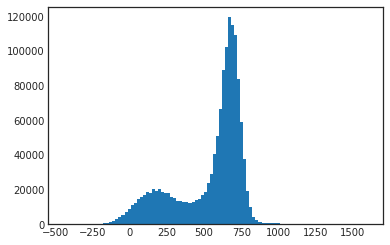

In [53]:
bins, vals, _ = plt.hist(
    patient[
        :mask.shape[0], 
        :mask.shape[1], 
        :mask.shape[2]
    ][mask[:patient.shape[0], :patient.shape[1], :patient.shape[2]]], 
    100
)

In [72]:
for pidx, path in tqdm(enumerate(paths)):
    print(path)
    print(pidx)
    patient, meta = load_utils.load_patient(PATHS['DATA'],  os.path.basename(path), metadata=True)
    row = labels_df[labels_df['Subject name or identifier'] == os.path.basename(path)]
    fact = meta['PixSpac']

    mask = glob(os.path.join(PATHS['DATA'], os.path.basename(path), '*_A.stl'))
    mask = load_utils.load_mesh(mask[0], meta) 
    mask = np.expand_dims(mask, -1)
    mask = mask[..., 0]
    
    patient = scipy.ndimage.zoom(patient, fact, order=3)
    mask = scipy.ndimage.zoom(mask, fact, order=0)
    
    prods = np.load(prods_paths[os.path.basename(path)])
    idx0, idx1 = valve_df[
        valve_df.seriesuid == os.path.basename(path)
    ][['idx0', 'idx1']].values[0]
    
    plt.imshow(mask.sum(1))
    plt.scatter(prods[idx0].mean(1)[2], prods[idx0].mean(1)[0]);
    plt.scatter(prods[idx1].mean(1)[2], prods[idx1].mean(1)[0]);
    plt.show()
    
    flipped = valve_df.loc[valve_df.seriesuid == os.path.basename(path), 'flipped'].values[0]
    if flipped:
        mask = np.flip(mask, 0)
        patient = np.flip(patient, 0)

    plt.imshow(mask.sum(1))
    plt.scatter(prods[idx0].mean(1)[2], prods[idx0].mean(1)[0]);
    plt.scatter(prods[idx1].mean(1)[2], prods[idx1].mean(1)[0]);
    plt.show()
    
    bins, vals, _ = plt.hist(
        patient[
            :mask.shape[0], 
            :mask.shape[1], 
            :mask.shape[2]
        ][mask[:patient.shape[0], :patient.shape[1], :patient.shape[2]]], 
        100
    )

    plt.show()
    
    cpred = np.zeros_like(mask)
    for i in range(idx0, idx1):
        coords = np.array([prods[i][0], prods[i][1], prods[i][2]])
        coords = np.clip(coords.T, 0, np.array(mask.shape) - 1)
        coords = np.round(coords).astype(np.int).T
        coords = tuple(c for c in coords)
        cpred[coords] = mask[coords]

    cpred = scipy.ndimage.binary_closing(cpred, iterations=15) & mask

    plt.imshow(cpred.sum(1))
    plt.show()
    
    
    
    try: 
        os.mkdir(os.path.join('/home/ubuntu/edata/', os.path.basename(path)))
    except:
        pass

    cdilated = mask * scipy.ndimage.binary_dilation(cpred, iterations=15)
    np.save(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'valve_mask'), cpred)
    np.save(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'valve_mask_dilated'), cdilated)
    
    np.save(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'mask'), mask)
    np.save(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'patient'), patient)
    np.save(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'bins'), bins)
    np.save(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'vals'), vals)
    np.save(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'vals'), vals)
    
    clear_output()

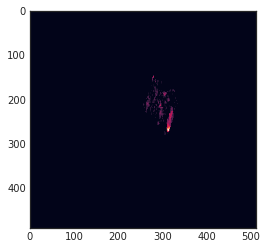

In [63]:
plt.imshow(((patient[
            :mask.shape[0], 
            :mask.shape[1], 
            :mask.shape[2]
        ] * mask[:patient.shape[0], :patient.shape[1], :patient.shape[2]] 
             * scipy.ndimage.binary_dilation(cpred[:patient.shape[0], :patient.shape[1], :patient.shape[2]], iterations=15)) > 800).sum(1))